# **Data Visualization of outliers in univariate and multivariate signal**

## Univariate dataset

In [16]:
from IPython.display import display

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)



# Catfish Sales Data

In [17]:
from datetime import datetime
from datetime import timedelta
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')
catfish_sales = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0, date_parser=parser)
import datetime
idx = pd.IndexSlice
catfish_sales.loc["1998-12-1"]['Total'] = 10000
start_date = datetime.datetime(1996,1,1)
end_date = datetime.datetime(2000,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

### Introduce an Anomaly

In [18]:
#At December 1 1998
lim_catfish_sales.iloc[0]

Total    20322
Name: 1996-01-01 00:00:00, dtype: int64

In [19]:
lim_catfish_sales

,Total
Date,
1996-01-01,20322
1996-02-01,20613
1996-03-01,22704
1996-04-01,20276
1996-05-01,20669
...,...
1999-09-01,24430
1999-10-01,25229
1999-11-01,22344


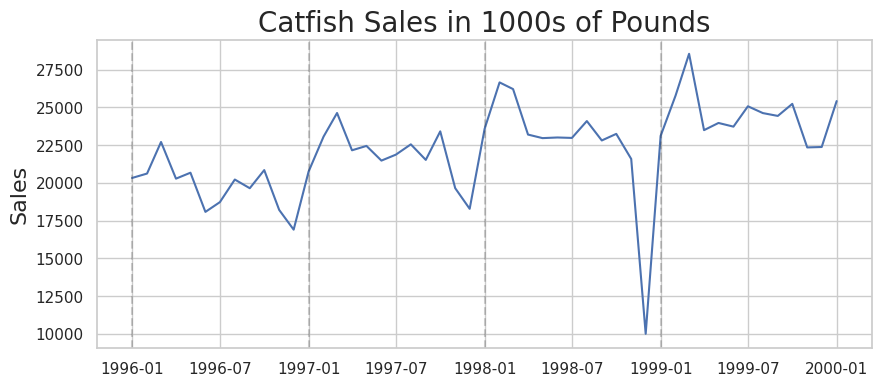

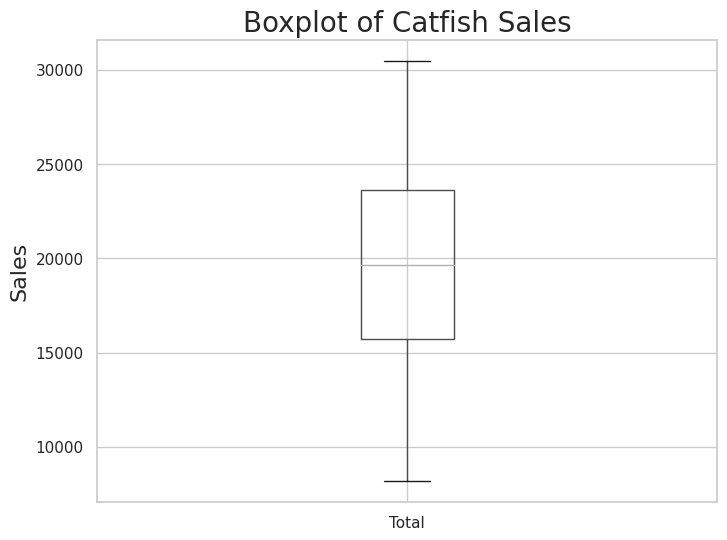

In [20]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

# Boxplot
plt.figure(figsize=(8, 6))
catfish_sales.boxplot(column=['Total'])
plt.title('Boxplot of Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.show()

## Seasonal Decompose

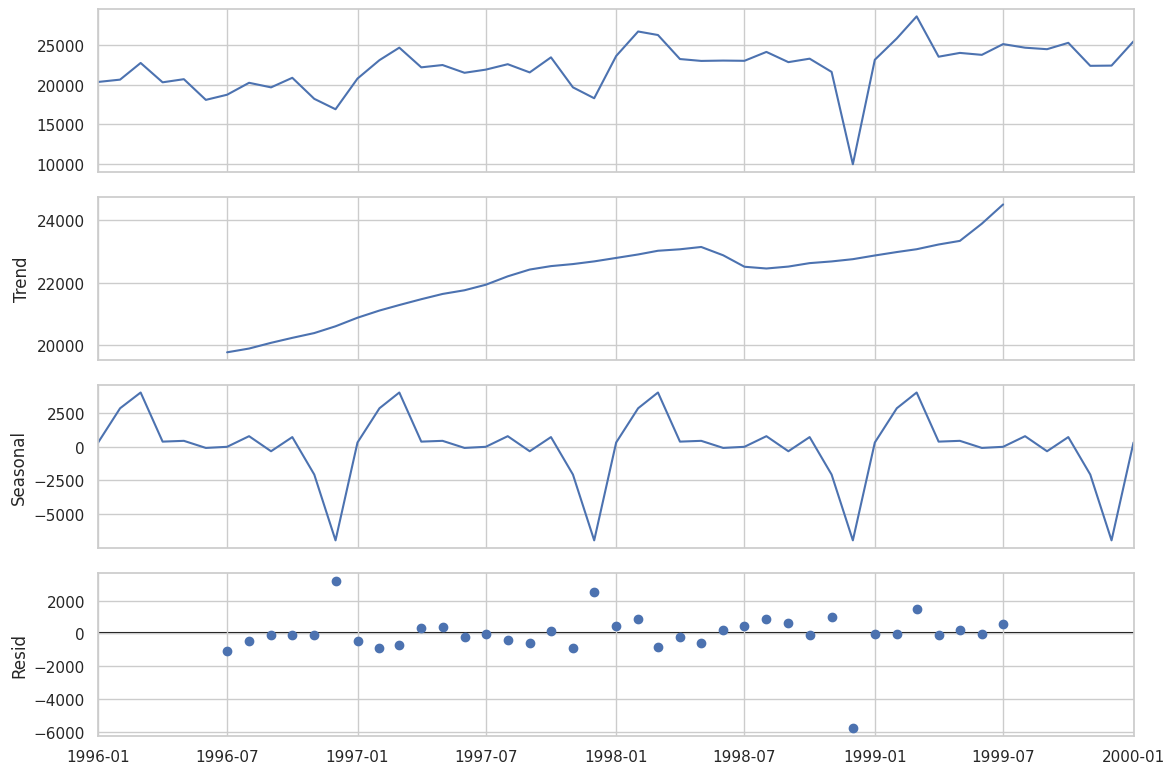

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
plt.rc('figure',figsize=(12,8))
plt.rc('font',size=15)

result = seasonal_decompose(lim_catfish_sales,model='additive')
fig = result.plot()

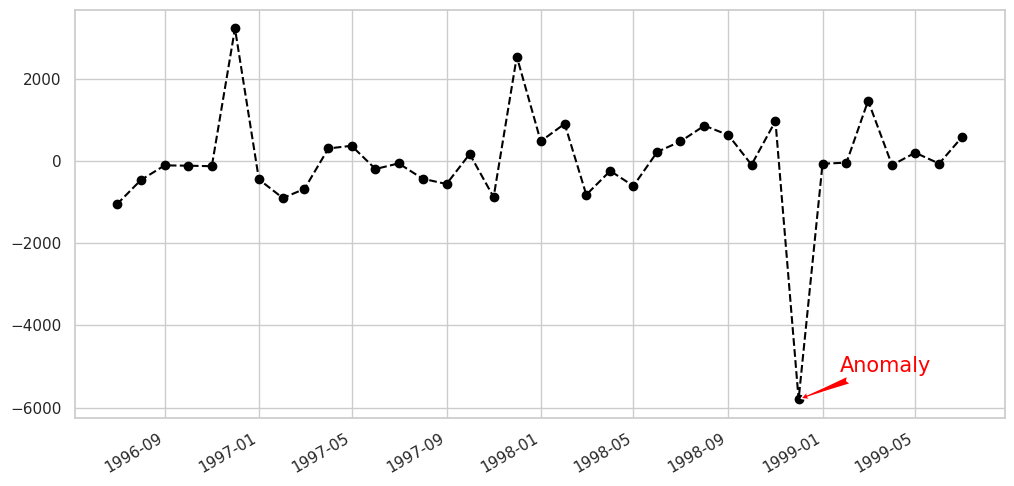

In [22]:
plt.rc('figure',figsize=(12,6))
plt.rc('font',size=15)

fig, ax = plt.subplots()
x = result.resid.index
y = result.resid.values
ax.plot_date(x, y, color='black',linestyle='--')

ax.annotate('Anomaly', (mdates.date2num(x[35]), y[35]), xytext=(30, 20),
           textcoords='offset points', color='red',arrowprops=dict(facecolor='red',arrowstyle='fancy'))

fig.autofmt_xdate()
plt.show()

### Introduce some more point outliers

In [23]:
catfish_sales.loc["1993-3-1"]['Total'] = 30000
catfish_sales.loc["2003-3-1"]['Total'] = 35000

## Isolation forest

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

<Axes: xlabel='Date'>

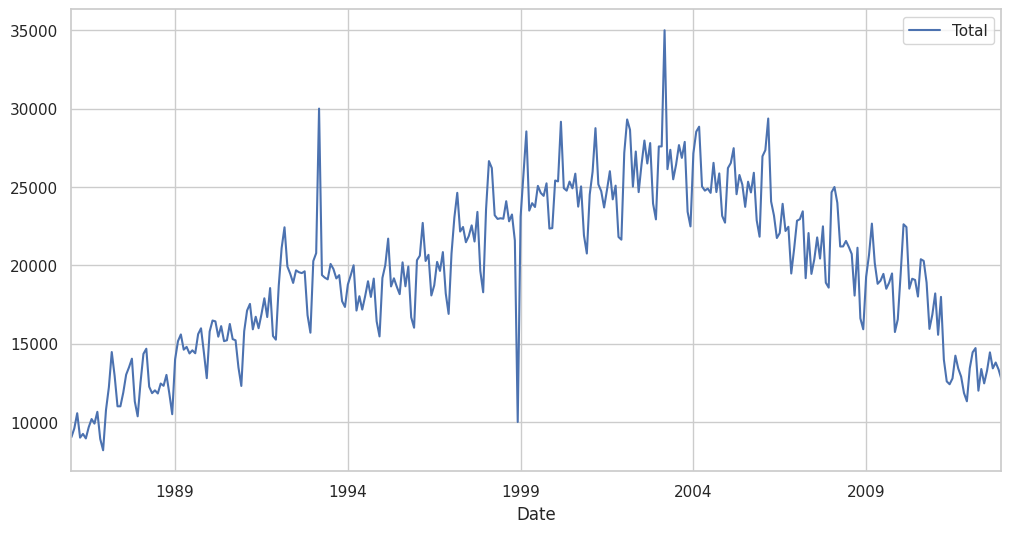

In [25]:
plt.rc('figure',figsize=(12,6))
plt.rc('font',size=15)
catfish_sales.plot()

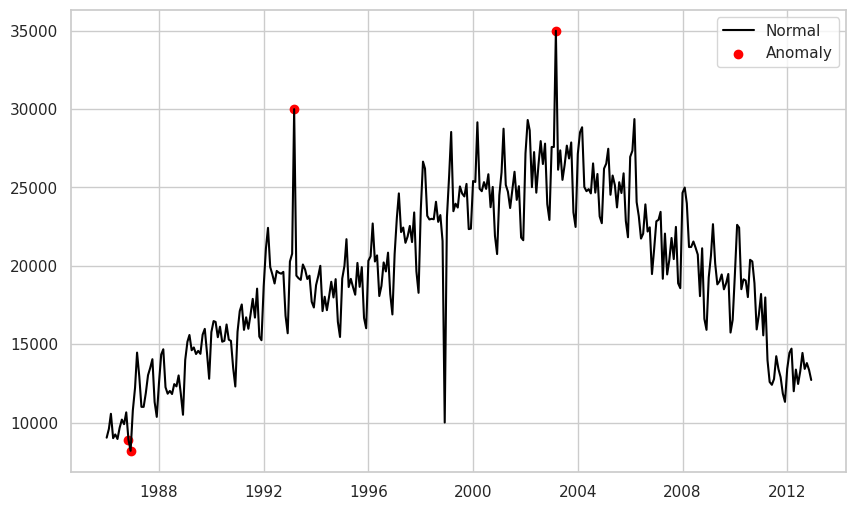

In [26]:
outliers_fraction = float(.01)
scaler = StandardScaler()
np_scaled = scaler.fit_transform(catfish_sales.values.reshape(-1, 1))
data = pd.DataFrame(np_scaled)
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data)
catfish_sales['anomaly'] = model.predict(data)

# visualization
fig, ax = plt.subplots(figsize=(10,6))

a = catfish_sales.loc[catfish_sales['anomaly'] == -1, ['Total']] #anomaly

ax.plot(catfish_sales.index, catfish_sales['Total'], color='black', label = 'Normal')
ax.scatter(a.index,a['Total'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

### Using K-mean for anomaly detection

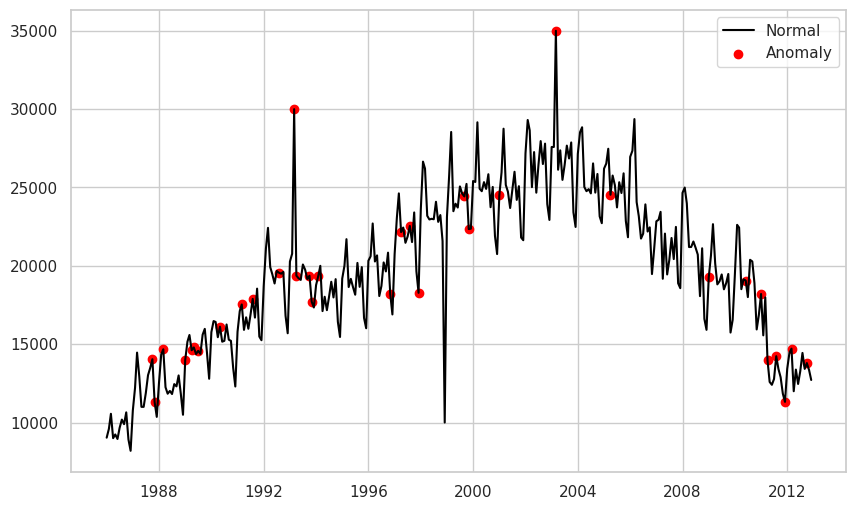

In [27]:
from sklearn.neighbors import LocalOutlierFactor
# KNN Outlier Detection
knn = LocalOutlierFactor(n_neighbors=5, contamination=0.1)
catfish_sales['anomaly'] = knn.fit_predict(data)

# visualization
fig, ax = plt.subplots(figsize=(10,6))

a = catfish_sales.loc[catfish_sales['anomaly'] == -1, ['Total']] #anomaly

ax.plot(catfish_sales.index, catfish_sales['Total'], color='black', label = 'Normal')
ax.scatter(a.index,a['Total'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

# Sectionwise Isolation Forest

9


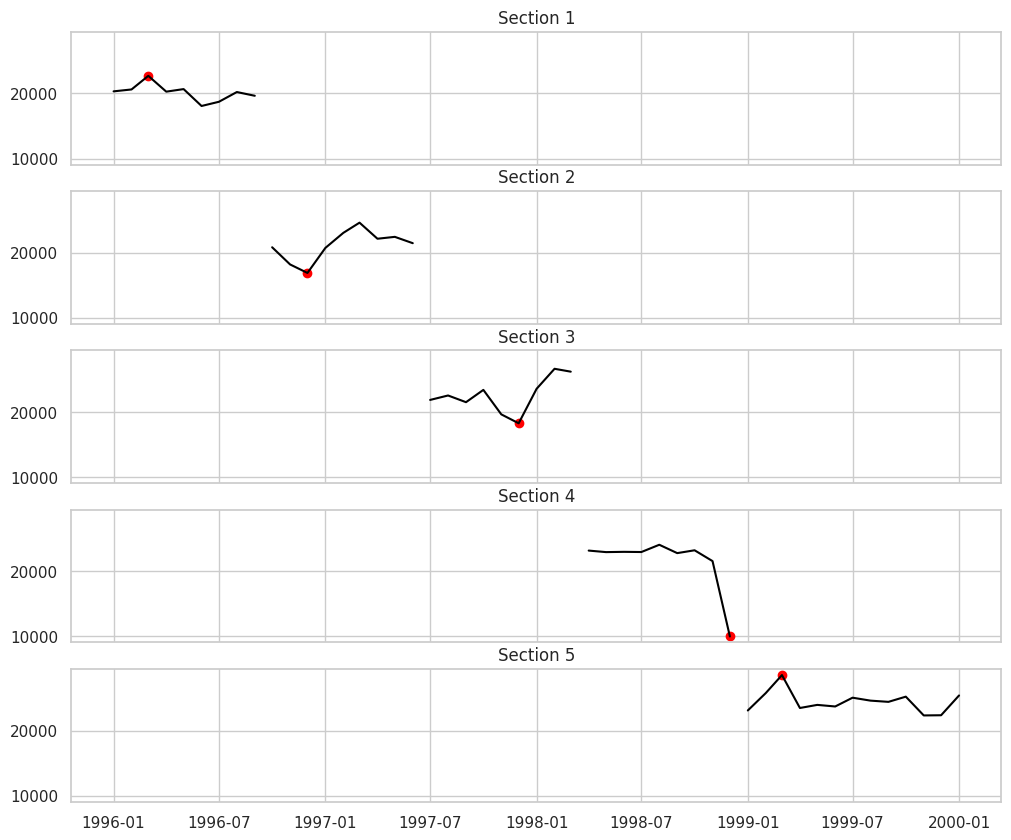

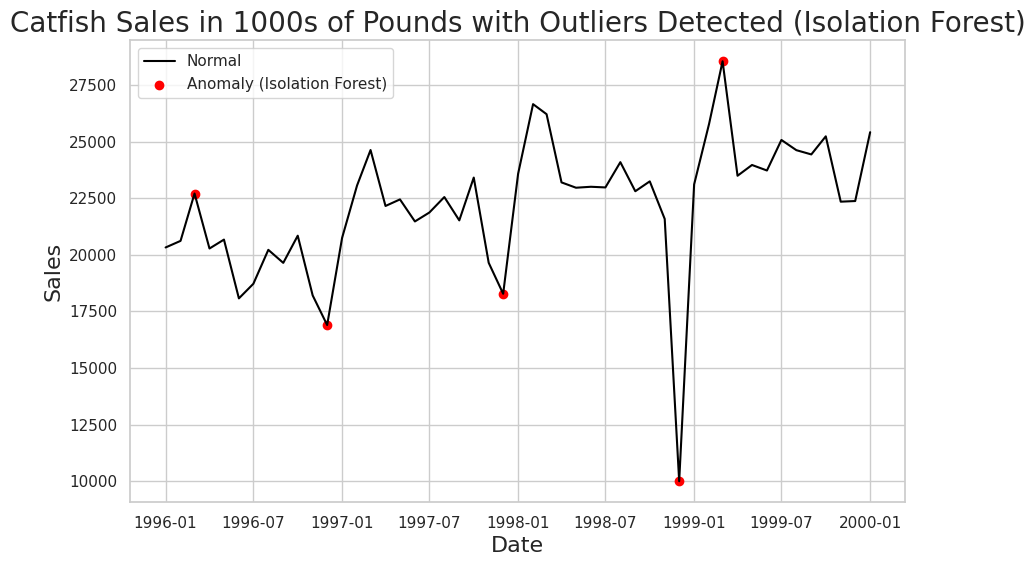

In [28]:
# Define the number of sections to split the data into
num_sections = 5
outliers_iforest = []

# Calculate the number of data points in each section
section_length = len(lim_catfish_sales) // num_sections
print(section_length)

# Create subplots for section-wise plots
fig, axs = plt.subplots(num_sections, 1, figsize=(12, 10), sharex=True, sharey=True)

# Iterate over each section
for i in range(num_sections):
    # Define the start and end indices for the current section
    start_index = i * section_length
    end_index = (i + 1) * section_length if i < num_sections - 1 else len(lim_catfish_sales)

    section_data = lim_catfish_sales.iloc[start_index:end_index,:1].copy()  # Ensure to make a copy

    # Scale the data
    scaler = StandardScaler()
    np_scaled = scaler.fit_transform(section_data.values.reshape(-1, 1))
    data = pd.DataFrame(np_scaled)

    # Perform outlier detection using Isolation Forest
    model_iforest = IsolationForest(contamination=outliers_fraction)
    model_iforest.fit(data)

    # Predict outliers for the current section
    predicted_outliers = model_iforest.predict(data)

    # Store the outliers
    outliers_iforest.extend(section_data[predicted_outliers == -1].index)

    # Plot the current section with outliers detected
    axs[i].plot(section_data.index, section_data['Total'], color='black', label='Normal')
    axs[i].scatter(section_data.index[predicted_outliers == -1], section_data['Total'][predicted_outliers == -1], color='red', label='Anomaly (Isolation Forest)')
    axs[i].set_title(f'Section {i+1}')

# Plot the merged plot
plt.figure(figsize=(10, 6))
plt.plot(lim_catfish_sales.index, lim_catfish_sales['Total'], color='black', label='Normal')
plt.scatter(outliers_iforest, lim_catfish_sales.loc[outliers_iforest, 'Total'], color='red', label='Anomaly (Isolation Forest)')
plt.title('Catfish Sales in 1000s of Pounds with Outliers Detected (Isolation Forest)', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.legend()
plt.show()


#**SVM**

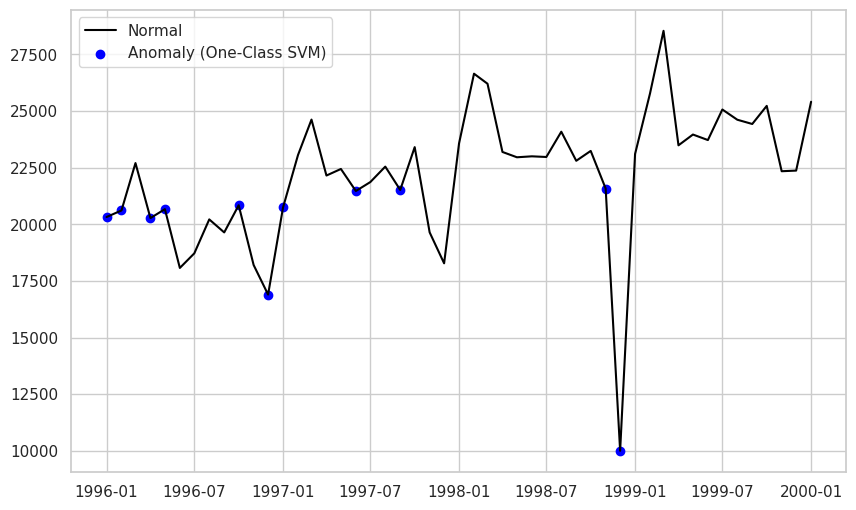

In [29]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Read the CSV file with date parsing
catfish_sales = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0)

# Manipulate some data points for illustration
catfish_sales.loc["1998-12-1", 'Total'] = 10000
catfish_sales.loc["1993-3-1", 'Total'] = 30000
catfish_sales.loc["2003-3-1", 'Total'] = 35000

# Define start and end dates for the time period of interest
start_date = '1996-01-01'
end_date = '2000-01-01'

# Subset the data to the specified time period
lim_catfish_sales = catfish_sales[start_date:end_date]

# Scale the data
scaler = StandardScaler()
np_scaled = scaler.fit_transform(lim_catfish_sales.values.reshape(-1, 1))
data = pd.DataFrame(np_scaled)

# Detect anomalies using Isolation Forest
outliers_fraction = 0.01
model_iforest = IsolationForest(contamination=outliers_fraction)
model_iforest.fit(data)
lim_catfish_sales['anomaly_iforest'] = model_iforest.predict(data)

# Detect anomalies using One-Class SVM
model_ocsvm = OneClassSVM(nu=outliers_fraction)
model_ocsvm.fit(data)
lim_catfish_sales['anomaly_ocsvm'] = model_ocsvm.predict(data)

# Plot anomalies detected by Isolation Forest and One-Class SVM
fig, ax = plt.subplots(figsize=(10, 6))

anomalies_ocsvm = lim_catfish_sales[lim_catfish_sales['anomaly_ocsvm'] == -1]

ax.plot(lim_catfish_sales.index, lim_catfish_sales['Total'], color='black', label='Normal')
ax.scatter(anomalies_ocsvm.index, anomalies_ocsvm['Total'], color='blue', label='Anomaly (One-Class SVM)')

plt.legend()
plt.show()


## Multivariate dataset

### Timeseries Expedia Data

In [30]:
from sklearn.cluster import KMeans
df = pd.read_csv('TimeSeriesExpedia.csv')

In [31]:
df.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,63,2013-05-23 11:56:25,14,100,NaN,NaN,219,104517,4,4.0,1,4.16,0.2534,5.30,15,69.87,1,8192,4,25,3,0,1,0,NaN,1937.85,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,90,2013-04-23 11:12:24,14,100,NaN,NaN,219,104517,4,4.0,1,4.16,0.2534,5.29,6,97.49,1,8192,2,44,1,0,1,1,NaN,1208.63,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,133,2013-03-14 11:27:28,5,219,NaN,NaN,219,104517,4,4.0,1,4.16,0.2534,5.29,29,206.00,1,8192,3,99,1,0,1,1,NaN,397.74,1,NaN,NaN,NaN,-1.0,0.0,2.0,-1.0,0.0,2.0,NaN,NaN,NaN,-1.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,148,2013-03-21 02:24:03,10,4,NaN,NaN,219,104517,4,4.0,1,4.16,0.2534,5.29,33,127.71,1,8192,4,227,1,0,1,0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
4,203,2013-01-03 20:48:24,5,219,NaN,NaN,219,104517,4,4.0,1,4.16,0.2534,5.29,6,186.00,1,8192,3,6,2,0,1,0,NaN,222.13,0,NaN,NaN,NaN,1.0,0.0,14.0,0.0,0.0,20.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,14.0,0,NaN,0


ISOLATION FOREST


In [32]:
# Select only the desired columns
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Apply Isolation Forest
model = IsolationForest(contamination=0.1)  # Adjust contamination parameter as needed
model.fit(data_imputed)

# Predict outliers
outliers = model.predict(data_imputed)

# Identify the outliers
outlier_indices = np.where(outliers == -1)[0]
outlier_data = data_imputed.iloc[outlier_indices]

# Print the indices of the outliers
print("Indices of outliers:", outlier_indices)

Indices of outliers: [ 2  3  7 13 17 52]


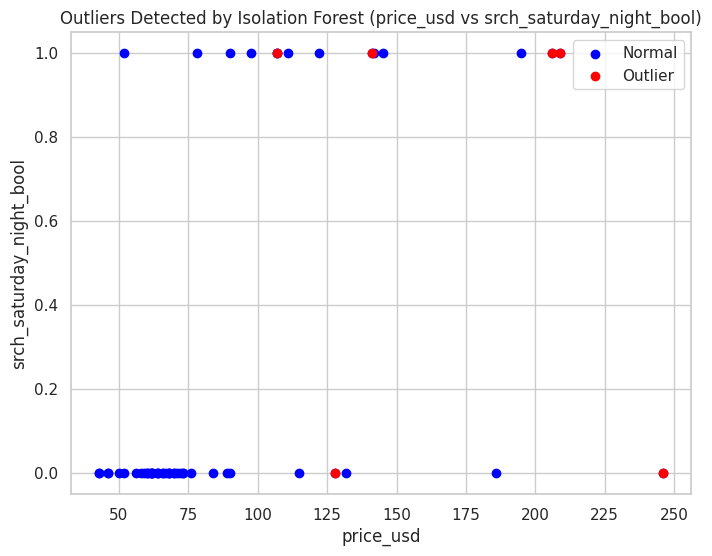

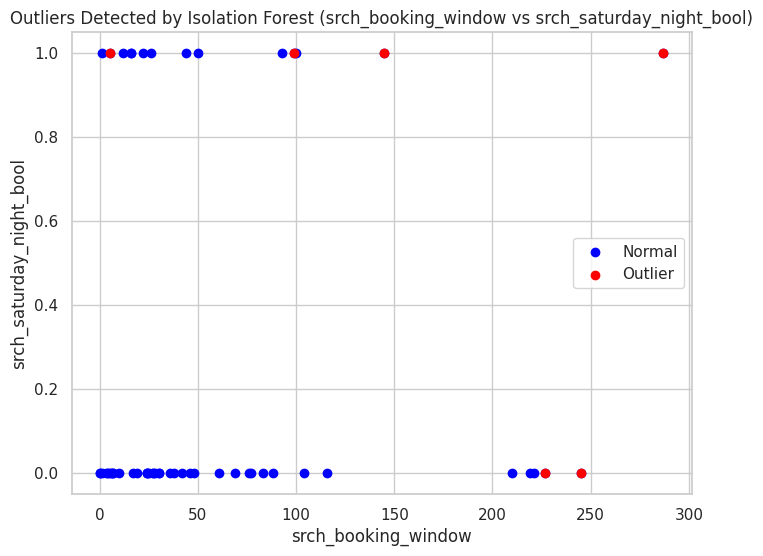

In [33]:
import matplotlib.pyplot as plt

# Plot each feature against the others
for feature in data_imputed.columns:
    if feature != 'srch_saturday_night_bool':
        plt.figure(figsize=(8, 6))
        plt.scatter(data_imputed[feature], data_imputed['srch_saturday_night_bool'], c='blue', label='Normal')
        plt.scatter(outlier_data[feature], outlier_data['srch_saturday_night_bool'], c='red', label='Outlier')
        plt.xlabel(feature)
        plt.ylabel('srch_saturday_night_bool')
        plt.title(f'Outliers Detected by Isolation Forest ({feature} vs srch_saturday_night_bool)')
        plt.legend()
        plt.show()


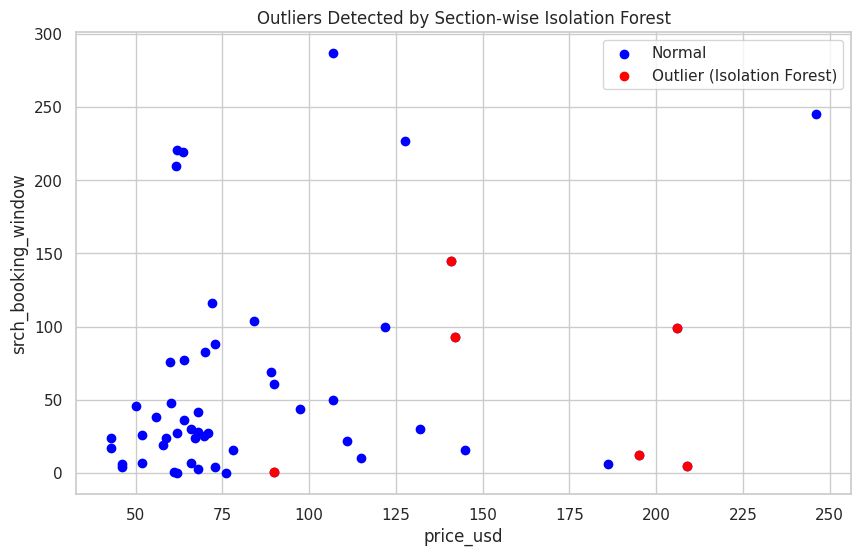

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the number of sections to split the data into
num_sections = 5
outliers_iforest = []

# Calculate the number of data points in each section
section_length = len(data_imputed) // num_sections

# Iterate over each section
for i in range(num_sections):
    # Define the start and end indices for the current section
    start_index = i * section_length
    end_index = (i + 1) * section_length if i < num_sections - 1 else len(data_imputed)

    # Extract the current section data
    section_data = data_imputed.iloc[start_index:end_index]

    # Apply standardization to the current section data
    scaler = StandardScaler()
    section_data_scaled = scaler.fit_transform(section_data)

    # Apply Isolation Forest to detect outliers in the current section
    model_iforest = IsolationForest(contamination=0.1)  # Adjust contamination parameter as needed
    model_iforest.fit(section_data_scaled)

    # Predict outliers for the current section
    predicted_outliers = model_iforest.predict(section_data_scaled)

    # Store the indices of the outliers
    outlier_indices = np.where(predicted_outliers == -1)[0]
    outliers_iforest.extend(outlier_indices + start_index)  # Convert indices back to original dataframe indices

# Plot the entire dataset with outliers detected by section-wise Isolation Forest
plt.figure(figsize=(10, 6))
plt.scatter(data_imputed['price_usd'], data_imputed['srch_booking_window'], c='blue', label='Normal')
plt.scatter(data_imputed.loc[outliers_iforest, 'price_usd'], data_imputed.loc[outliers_iforest, 'srch_booking_window'], c='red', label='Outlier (Isolation Forest)')
plt.xlabel('price_usd')
plt.ylabel('srch_booking_window')
plt.title('Outliers Detected by Section-wise Isolation Forest')
plt.legend()
plt.show()


## Kmeans

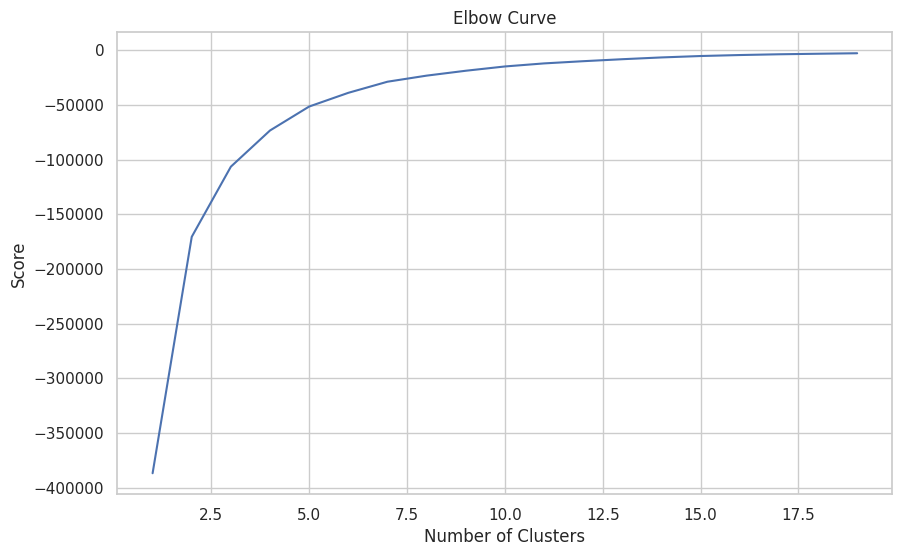

In [35]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

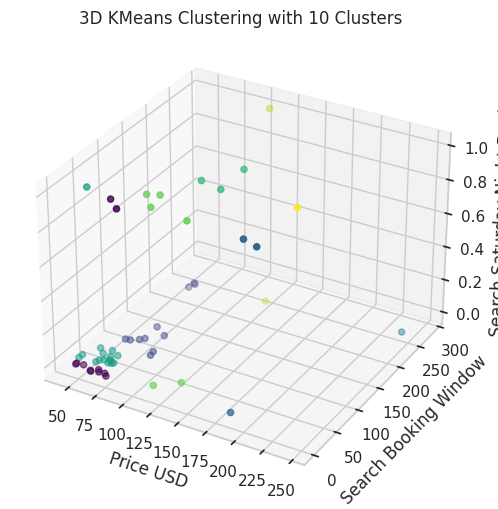

In [36]:
from mpl_toolkits.mplot3d import Axes3D
n_clusters=10
# Fit KMeans with the specified number of clusters
kmeans_model_3d = KMeans(n_clusters=n_clusters).fit(data)

# Get the cluster labels for each data point
cluster_labels_3d = kmeans_model_3d.labels_

# Plotting the clusters in 3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(data['price_usd'], data['srch_booking_window'], data['srch_saturday_night_bool'], c=cluster_labels_3d, cmap='viridis')

# Set labels and title
ax.set_xlabel('Price USD')
ax.set_ylabel('Search Booking Window')
ax.set_zlabel('Search Saturday Night Bool')
plt.title('3D KMeans Clustering with 10 Clusters')

plt.show()


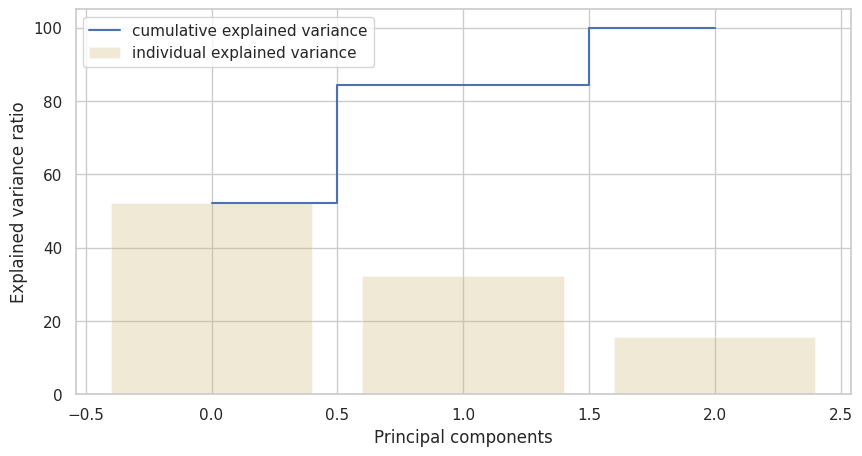

In [37]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X = data.values
X_std = StandardScaler().fit_transform(X)
#Calculating Eigenvecors and eigenvalues of Covariance matrix
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'y')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

In [38]:
# Take useful feature and standardize them
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X_std = StandardScaler().fit_transform(X)
data = pd.DataFrame(X_std)
# reduce to 2 important features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [39]:
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
df['cluster'] = kmeans[9].predict(data)
df.index = data.index
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

6    12
1    12
3     8
4     4
0     4
2     4
8     3
7     3
5     2
9     2
Name: cluster, dtype: int64

In [40]:
kmeans[9]

KMeans(n_clusters=10)

In [41]:
# return Series of distance between each point and its distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i]=np.linalg.norm(Xa-Xb)
    return distance

outliers_fraction = 0.1
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[9])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly)
df['anomaly1'] = (distance >= threshold).astype(int)

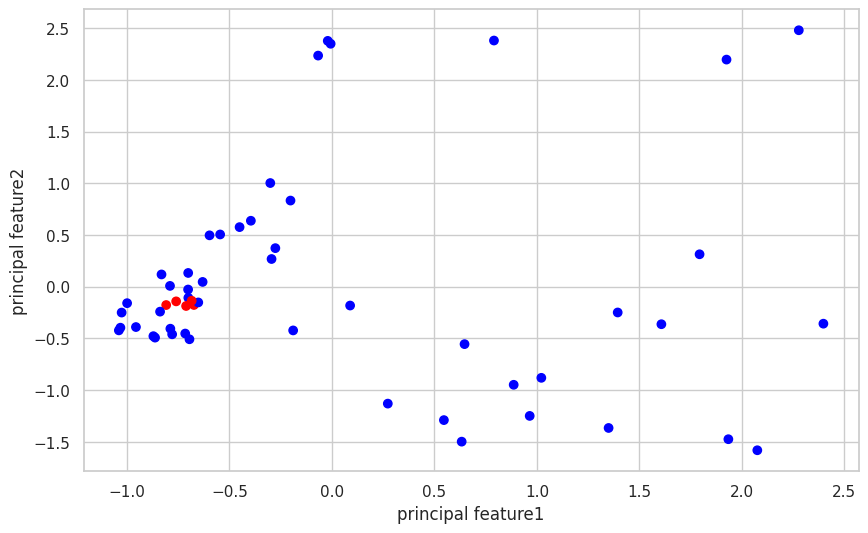

In [42]:
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show();

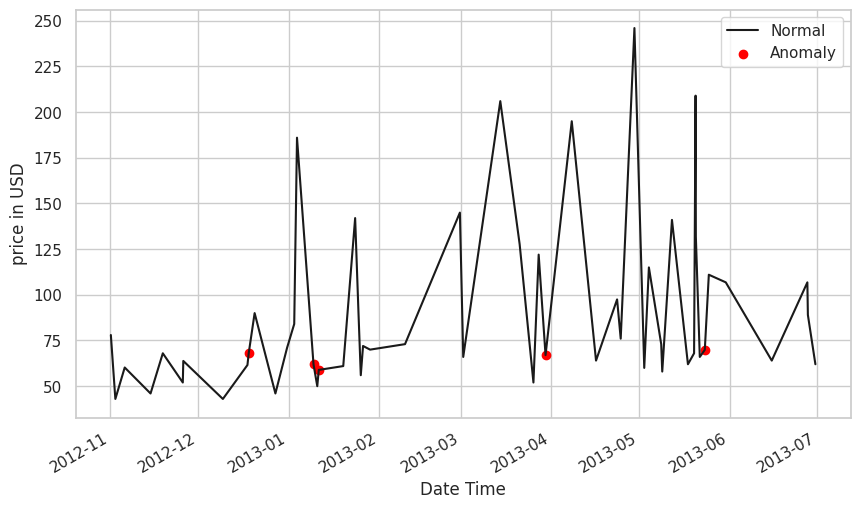

In [43]:
df = df.sort_values('date_time')
#df['date_time_int'] = df.date_time.astype(np.int64)
fig, ax = plt.subplots(figsize=(10,6))

a = df.loc[df['anomaly1'] == 1, ['date_time','price_usd']] #anomaly


ax.plot(pd.to_datetime(df['date_time']), df['price_usd'], color='k',label='Normal')
ax.scatter(pd.to_datetime(a['date_time']),a['price_usd'], color='red', label='Anomaly')
ax.xaxis_date()
plt.xlabel('Date Time')
plt.ylabel('price in USD')
plt.legend()
fig.autofmt_xdate()
plt.show()